In [1]:
#Importing important librarys
import pandas as pd
import time
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
le = LabelEncoder()
import warnings
warnings.filterwarnings('ignore')

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
mBusData = pd.read_csv('D:/TON IOT/Processed_datasets/Processed_datasets/Processed_IoT_dataset/IoT_Modbus.csv')
mBusData.head()

,date,time,FC1_Read_Input_Register,FC2_Read_Discrete_Value,FC3_Read_Holding_Register,FC4_Read_Coil,label,type
0,31-Mar-19,12:36:55,53287,1463,33518,23014,0,normal
1,31-Mar-19,12:36:58,41029,55891,26004,50645,0,normal
2,31-Mar-19,12:36:58,41029,55891,26004,50645,0,normal
3,31-Mar-19,12:37:00,64661,40232,33460,44046,0,normal
4,31-Mar-19,12:37:01,64661,40232,33460,44046,0,normal


In [4]:
mBusData.drop('type', axis = 1, inplace=True)
mBusData.drop(mBusData.iloc[:, 0:2], axis = 1, inplace=True)
mBusData.head()

,FC1_Read_Input_Register,FC2_Read_Discrete_Value,FC3_Read_Holding_Register,FC4_Read_Coil,label
0,53287,1463,33518,23014,0
1,41029,55891,26004,50645,0
2,41029,55891,26004,50645,0
3,64661,40232,33460,44046,0
4,64661,40232,33460,44046,0


In [5]:
# import matplotlib.pyplot as plt
# columns = mBusData.columns
# for col in columns:
#     print("col: ", col)
#     mBusData[col].hist(bins = 100)
#     plt.show()

<AxesSubplot: >

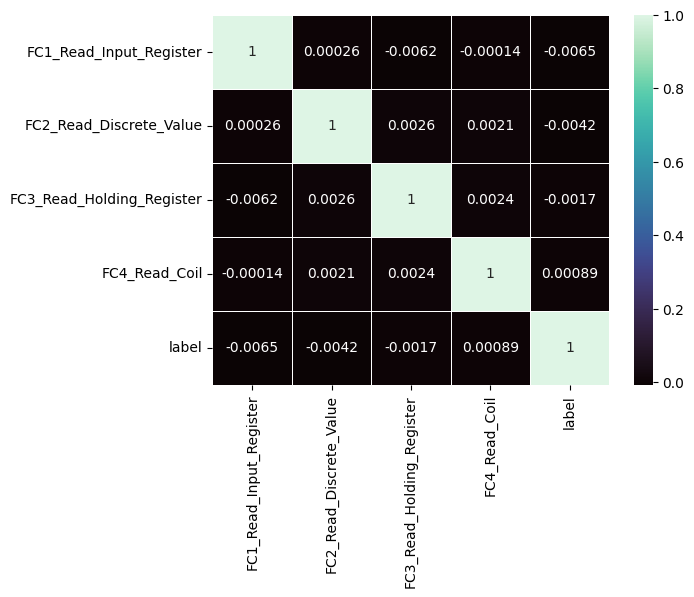

In [6]:
sns.heatmap(mBusData.corr(), annot=True, linewidth = 0.5, cmap='mako')

# **Train Test with Skfold**

In [6]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=8, shuffle = True, random_state=3)

x=mBusData[['FC1_Read_Input_Register','FC2_Read_Discrete_Value','FC3_Read_Holding_Register','FC4_Read_Coil']]
y=mBusData['label' ]

# Without Oversampling

In [7]:
# --------------------------Random Forest -----------------------------------
for train_index, test_index in skf.split(x, y):
    x_train, x_test, y_train, y_test = x.iloc[train_index], x.iloc[test_index], y.iloc[train_index], y.iloc[test_index]
    
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=10, random_state=1)
rfc.fit(x_train, y_train) #Training the model
y_pred_rfc = rfc.predict(x_test)
print(y_pred_rfc)# printing predictions

#Accuracy Score

from sklearn.metrics import accuracy_score
rfcAccuracy = round(accuracy_score(y_test, y_pred_rfc)*100,2)
print("Accuracy of rfc: ",rfcAccuracy)

#F1 Score

from sklearn.metrics import f1_score
rfcF1 = round(f1_score(y_test, y_pred_rfc)*100,2)
print("f1_score of rfc: ",rfcF1)

#AUC Score

from sklearn.metrics import roc_auc_score
rfcAuc = round(roc_auc_score (y_test, y_pred_rfc)*100,2)
print('AUC Score of rfc:',rfcAuc)

[0 0 0 ... 0 0 0]
Accuracy of rfc:  96.41
f1_score of rfc:  91.53
AUC Score of rfc: 92.93


<AxesSubplot: >

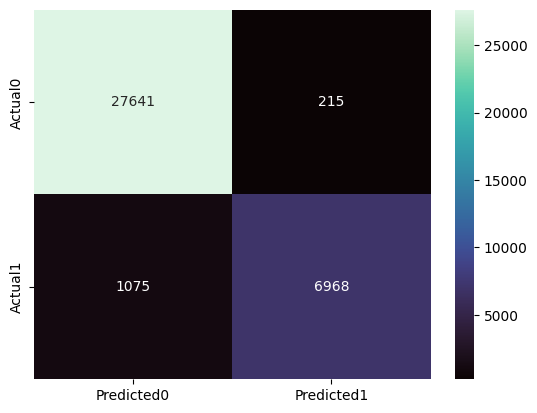

In [8]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
def plot(y_true, y_pred):
    labels = unique_labels(y_test)
    column = [f'Predicted{label}' for label in labels]
    indices = [f'Actual{label}' for label in labels]
    table = pd.DataFrame(confusion_matrix(y_true, y_pred), columns = column, index=indices)
    return sns.heatmap(table, annot = True, fmt = 'd', cmap = 'mako' )

plot(y_test, y_pred_rfc)

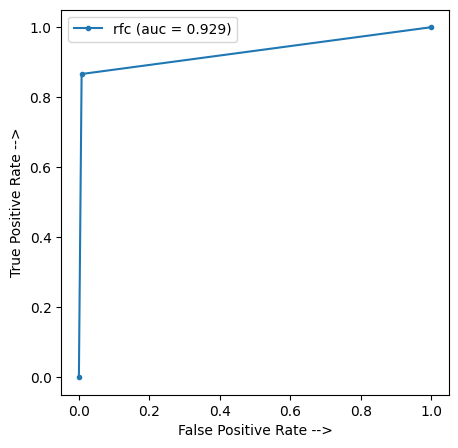

In [9]:
#ROC CURVE:
from sklearn.metrics import roc_curve, auc

rfc_fpr, rfc_tpr, threshold = roc_curve(y_test, y_pred_rfc)
auc_rfc = auc(rfc_fpr, rfc_tpr)

plt.figure(figsize=(5, 5), dpi=100)
plt.plot(rfc_fpr, rfc_tpr, marker='.', label='rfc (auc = %0.3f)' % auc_rfc)

plt.xlabel('False Positive Rate -->')
plt.ylabel('True Positive Rate -->')

plt.legend()

plt.show()

# Oversampling

In [10]:
from imblearn.over_sampling import SMOTE
import numpy as np
#Seeing the value count before oversampling
unique, count = np.unique(y_train, return_counts = True)
y_train_dict_value_count = {k:v for (k,v) in zip(unique, count)}
print("Before oversampling",y_train_dict_value_count)

sm = SMOTE(random_state=12)
x_train_sm, y_train_sm = sm.fit_sample(x_train, y_train)

# Seeing the value count after oversampling
unique, count = np.unique(y_train_sm, return_counts = True)
y_train_smote_value_count = {k:v for (k,v) in zip(unique, count)}
print("After oversampling",y_train_smote_value_count)

Before oversampling {0: 194999, 1: 56296}
After oversampling {0: 194999, 1: 194999}


In [11]:
# --------------------------Random Forest -----------------------------------
for train_index, test_index in skf.split(x_train_sm, y_train_sm):
    x_train, x_test, y_train, y_test = x_train_sm.iloc[train_index], x_train_sm.iloc[test_index], y_train_sm.iloc[train_index], y_train_sm.iloc[test_index]
    
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=10, random_state=1)
rfc.fit(x_train, y_train) #Training the model
y_pred_rfc = rfc.predict(x_test)
print(y_pred_rfc)# printing predictions


#Accuracy Score

from sklearn.metrics import accuracy_score
ovr_rfcAccuracy = round(accuracy_score(y_test, y_pred_rfc)*100,2)
print("Accuracy of rfc after oversampling:",ovr_rfcAccuracy)

#F1 Score

from sklearn.metrics import f1_score
ovr_rfcF1 = round(f1_score(y_test, y_pred_rfc)*100,2)
print("f1_score of rfc after oversampling:",ovr_rfcF1)

#AUC Score

from sklearn.metrics import roc_auc_score
ovr_rfcAuc = round(roc_auc_score (y_test, y_pred_rfc)*100,2)
print('AUC Score of rfc after oversampling:', ovr_rfcAuc)

[0 0 0 ... 1 1 1]
Accuracy of rfc after oversampling: 94.34
f1_score of rfc after oversampling: 94.21
AUC Score of rfc after oversampling: 94.34


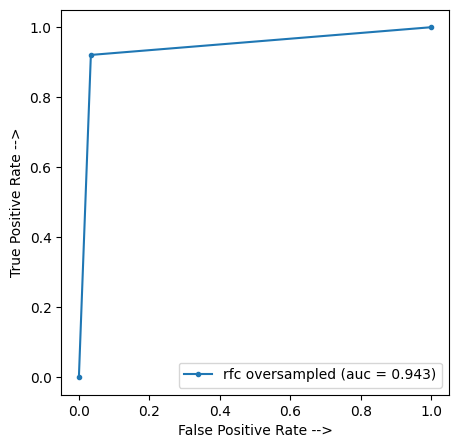

In [12]:
#ROC CURVE:
from sklearn.metrics import roc_curve, auc

rfc_fpr, rfc_tpr, threshold = roc_curve(y_test, y_pred_rfc)
auc_rfc = auc(rfc_fpr, rfc_tpr)

plt.figure(figsize=(5, 5), dpi=100)
plt.plot(rfc_fpr, rfc_tpr, marker='.', label='rfc oversampled (auc = %0.3f)' % auc_rfc)

plt.xlabel('False Positive Rate -->')
plt.ylabel('True Positive Rate -->')

plt.legend()

plt.show()

<AxesSubplot: >

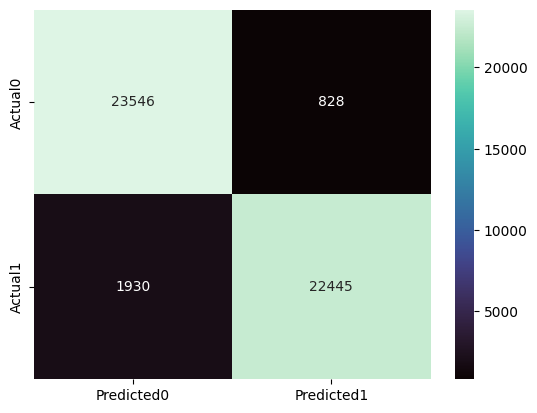

In [13]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
def plot(y_true, y_pred):
    labels = unique_labels(y_test)
    column = [f'Predicted{label}' for label in labels]
    indices = [f'Actual{label}' for label in labels]
    table = pd.DataFrame(confusion_matrix(y_true, y_pred), columns = column, index=indices)
    return sns.heatmap(table, annot = True, fmt = 'd', cmap = 'mako' )

plot(y_test, y_pred_rfc)

# Undersampling

In [14]:
x=mBusData[['FC1_Read_Input_Register','FC2_Read_Discrete_Value','FC3_Read_Holding_Register','FC4_Read_Coil']]
y=mBusData['label' ]

In [15]:


for train_index, test_index in skf.split(x, y):
    x_train, x_test, y_train, y_test = x.iloc[train_index], x.iloc[test_index], y.iloc[train_index], y.iloc[test_index]

from imblearn.under_sampling import RandomUnderSampler
import numpy as np
from collections import Counter

#Seeing the value count before oversampling
print("Before undersampling", Counter(y_train))

rus = RandomUnderSampler(random_state=12)
x_unsampled, y_unsampled = rus.fit_sample(x_train, y_train)

# Seeing the value count after oversampling
print("After undersampling",Counter(y_unsampled))


Before undersampling Counter({0: 194999, 1: 56296})
After undersampling Counter({0: 56296, 1: 56296})


In [16]:
for train_index, test_index in skf.split(x_unsampled, y_unsampled):
    x_train, x_test, y_train, y_test = x_unsampled.iloc[train_index], x_unsampled.iloc[test_index], y_unsampled.iloc[train_index], y_unsampled.iloc[test_index]
    
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=10, random_state=1)
rfc.fit(x_train, y_train) #Training the model
y_pred_rfc = rfc.predict(x_test)
print(y_pred_rfc)# printing predictions


#Accuracy Score

from sklearn.metrics import accuracy_score
und_rfcAccuracy = round(accuracy_score(y_test, y_pred_rfc)*100,2)
print("Accuracy of rfc undersampled : ",und_rfcAccuracy)

#F1 Score

from sklearn.metrics import f1_score
und_rfcF1 = round(f1_score(y_test, y_pred_rfc)*100,2)
print("f1_score of rfc undersampled: ",und_rfcF1)

#AUC Score

from sklearn.metrics import roc_auc_score
try:
  und_rfcAuc = round(roc_auc_score (y_test, y_pred_rfc)*100,2)
  print('AUC Score of rfc undersampled:', und_rfcAuc)
except ValueError:
    pass



[1 0 0 ... 0 1 0]
Accuracy of rfc undersampled :  86.76
f1_score of rfc undersampled:  86.91
AUC Score of rfc undersampled: 86.76


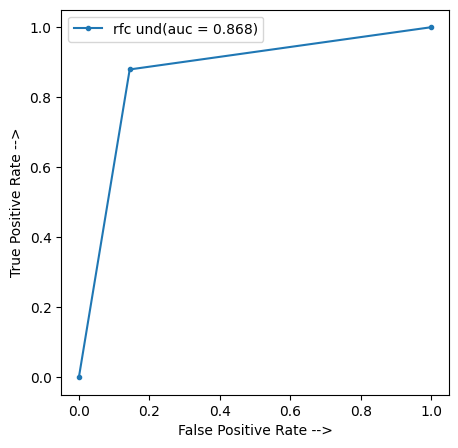

In [17]:
#ROC CURVE:
from sklearn.metrics import roc_curve, auc

rfc_fpr, rfc_tpr, threshold = roc_curve(y_test, y_pred_rfc)
auc_rfc = auc(rfc_fpr, rfc_tpr)

plt.figure(figsize=(5, 5), dpi=100)
plt.plot(rfc_fpr, rfc_tpr, marker='.', label='rfc und(auc = %0.3f)' % auc_rfc)

plt.xlabel('False Positive Rate -->')
plt.ylabel('True Positive Rate -->')

plt.legend()

plt.show()

<AxesSubplot: >

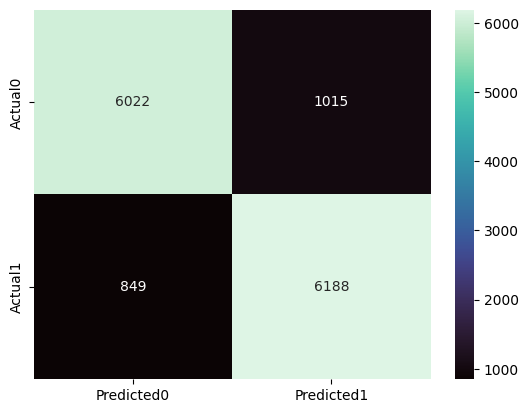

In [18]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
def plot(y_true, y_pred):
    labels = unique_labels(y_test)
    column = [f'Predicted{label}' for label in labels]
    indices = [f'Actual{label}' for label in labels]
    table = pd.DataFrame(confusion_matrix(y_true, y_pred), columns = column, index=indices)
    return sns.heatmap(table, annot = True, fmt = 'd', cmap = 'mako' )

plot(y_test, y_pred_rfc)

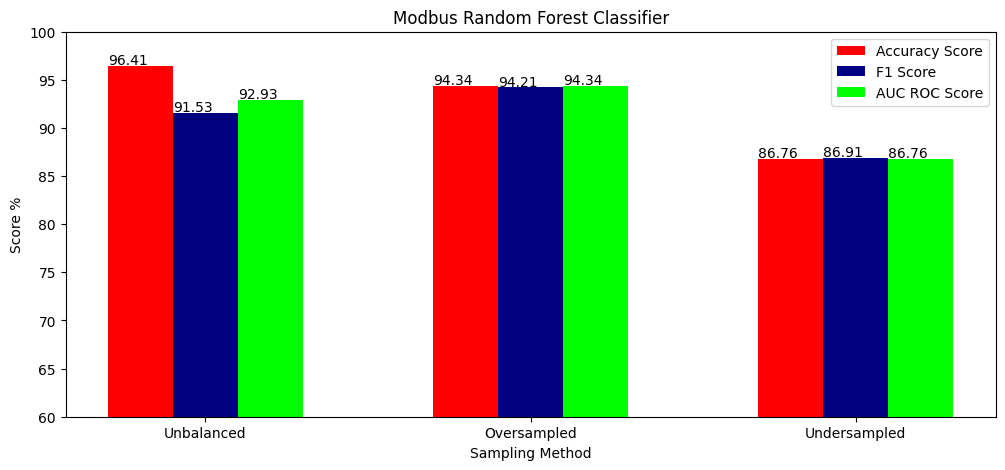

In [19]:
#Plotting a bar graph to compare the accuracy scores of the different scoring metrics
all_accuracy_scores = [rfcAccuracy, ovr_rfcAccuracy, und_rfcAccuracy]
all_f1_scores = [rfcF1, ovr_rfcF1, und_rfcF1]
all_auc_roc_scores = [rfcAuc, ovr_rfcAuc, und_rfcAuc]

x_labels = ['Unbalanced', 'Oversampled', 'Undersampled']

def autolabel(rectangle_group):
    for rect in rectangle_group:
        height = rect.get_height()

        ax.annotate(str(height), xy = (rect.get_x(), height+.15))

width = 0.2

x_all_accuracy_score = [x-width for x in range (len(all_accuracy_scores))]
x_all_f1_score = [x for x in range (len(all_f1_scores))]
x_all_auc_roc_score = [x+width for x in range (len(all_auc_roc_scores))]

fig,ax = plt.subplots(figsize = (12, 5))
rect1 = ax.bar(x_all_accuracy_score ,all_accuracy_scores, width, label='Accuracy Score', color = 'red')
rect2 = ax.bar(x_all_f1_score, all_f1_scores, width, label='F1 Score', color='navy')
rect3 = ax.bar(x_all_auc_roc_score, all_auc_roc_scores, width, label='AUC ROC Score', color='lime')
plt.xticks([x for x in range(len(x_labels))], x_labels)
ax.set_title('Modbus Random Forest Classifier')
ax.set_xlabel('Sampling Method')
ax.set_ylabel('Score %')
plt.ylim([60, 100])
ax.legend()

autolabel(rect1)
autolabel(rect2)
autolabel(rect3)
plt.show()